<a href="https://colab.research.google.com/github/IoannisKero/EEE-560-002-Survey-Design-for-Engineers-/blob/main/homework_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3


## References

+ Lectures 8-12 (inclusive).

## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

In [ ]:
MAKE_BOOK_FIGURES=True
import numpy as np
import scipy.stats as st

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,

        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,

        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,

        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,

        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,

        # Remove legend frame
        'legend.frameon': False,

        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def set_notebook_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings - using default sizes
        'font.family': 'serif',
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,

        # Line and marker settings
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,

        # Layout settings
        'figure.constrained_layout.use': True,

        # Remove only top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,

        # Remove legend frame
        'legend.frameon': False,

        # Additional settings
        'figure.autolayout': True,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.

    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'

    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)

def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
else:
    set_notebook_style()

make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

## Student details

+ **First Name:** Ioannis
+ **Last Name:** Keroglou
+ **Email:** ikeroglo@purdue.edu

## Problem 1 - Propagating uncertainty through a differential equation

This is a classic uncertainty propagation problem you must solve using Monte Carlo sampling.
Consider the following stochastic harmonic oscillator:

$$
\begin{array}{ccc}
\ddot{y} + 2 \zeta \omega(X) \dot{y} + \omega^2(X)y &=& 0,\\
y(0) &=& y_0(X),\\
\dot{y}(0) &=& v_0(X),
\end{array}
$$

where:
+ $X = (X_1, X_2, X_3)$,
+ $X_i \sim N(0, 1)$,
+ $\omega(X) = 2\pi + X_1$,
+ $\zeta = 0.01$,
+ $y_0(X) = 1+ 0.1 X_2$, and
+ $v_0 = 0.1 X_3$.

In other words, this stochastic harmonic oscillator has an uncertain natural frequency and uncertain initial conditions.

Our goal is to propagate uncertainty through this dynamical system, i.e., estimate the mean and variance of its solution.
A solver for this dynamical system is given below:

In [ ]:
import scipy.integrate

class Solver(object):
    def __init__(
        self,
        nt=100,
        T= 5
    ):
        """This is the initializer of the class.

        Arguments:
            nt -- The number of timesteps.
            T  -- The final time.
        """
        self.nt = nt
        self.T = T
        # The timesteps on which we will get the solution
        self.t = np.linspace(0, T, nt)
        # The number of inputs the class accepts
        self.num_input = 3
        # The number of outputs the class returns
        self.num_output = nt

    def __call__(self, x):
        """This special class method emulates a function call.

        Arguments:
            x -- A 1D numpy array with 3 elements.
                 This represents the stochastic input x = (x1, x2, x3).

        Returns the solution to the differential equation evaluated
        at discrete timesteps.
        """
        # uncertain quantities
        x1 = x[0]
        x2 = x[1]
        x3 = x[2]

        # ODE parameters
        omega = 2*np.pi + x1
        y10 = 1 + 0.1*x2
        y20 = 0.1*x3
        # initial conditions
        y0 = np.array([y10, y20])

        # coefficient matrix
        zeta = 0.01
        # spring constant
        k = omega**2
        # damping coeff
        c = 2*zeta*omega
        C = np.array([[0, 1],[-k, -c]])

        #RHS of the ODE system
        def rhs(y, t):
            return np.dot(C, y)

        y = scipy.integrate.odeint(rhs, y0, self.t)

        return y

First, let's demonstrate how the solver works:

In [ ]:
solver = Solver()

x = np.random.randn(solver.num_input)

y = solver(x)

print(y)

[[ 1.00260619 -0.1415957 ]
 [ 0.93582957 -2.4733814 ]
 [ 0.75802451 -4.49434842]
 [ 0.49114296 -5.96587968]
 [ 0.16759707 -6.71646833]
 [-0.17367477 -6.66168556]
 [-0.49189205 -5.81363601]
 [-0.74930332 -4.27884702]
 [-0.91566279 -2.24492351]
 [-0.97178169  0.04236408]
 [-0.91173777  2.30876276]
 [-0.74348897  4.28440765]
 [-0.48782921  5.73594218]
 [-0.17582216  6.49406639]
 [ 0.15497065  6.47326307]
 [ 0.46500981  5.68140554]
 [ 0.71750225  4.21817277]
 [ 0.88276561  2.26253838]
 [ 0.94171523  0.0508991 ]
 [ 0.88806442 -2.15148621]
 [ 0.7289848  -4.08229838]
 [ 0.48415867 -5.51338918]
 [ 0.18334752 -6.27772532]
 [-0.13722348 -6.2888649 ]
 [-0.43922595 -5.55069747]
 [-0.68680915 -4.15635499]
 [-0.85085392 -2.27649846]
 [-0.91239521 -0.13844905]
 [-0.8648112   2.00128642]
 [-0.71452665  3.88777685]
 [-0.48015717  5.2980274 ]
 [-0.19020696  6.06732496]
 [ 0.12039553  6.10845784]
 [ 0.41450335  5.42156894]
 [ 0.65719192  4.09353368]
 [ 0.81990443  2.2870094 ]
 [ 0.8838099   0.22053212]
 

Notice the dimension of `y`:

In [ ]:
y.shape

(100, 2)

The 100 rows corresponds to timesteps.
The 2 columns correspond to position and velocity.

Let's plot a few samples:

<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-110166671.py:7: SyntaxWarning: invalid escape sequence '\d'
  ax2.set_ylabel('$\dot{y}(t)$ (Velocity)')


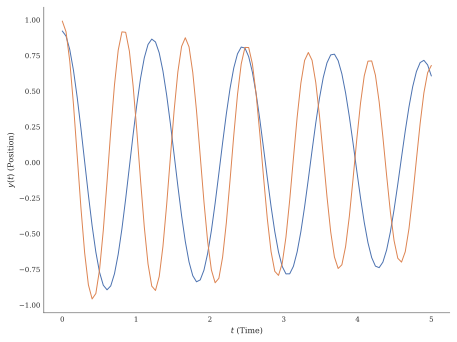

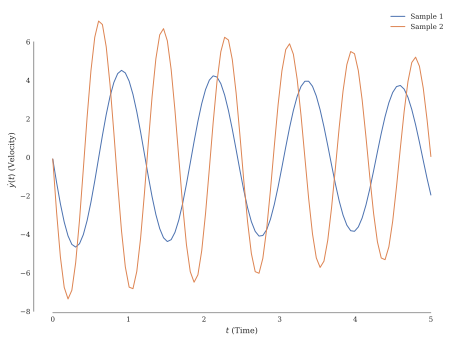

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('$t$ (Time)')
ax1.set_ylabel('$y(t)$ (Position)')

fig2, ax2 = plt.subplots()
ax2.set_xlabel('$t$ (Time)')
ax2.set_ylabel('$\dot{y}(t)$ (Velocity)')

for i in range(2):
    x = np.random.randn(solver.num_input)
    y = solver(x)

    ax1.plot(solver.t, y[:, 0])
    ax2.plot(
        solver.t, y[:, 1],
        label=f'Sample {i+1:d}')
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

For your convenience, here is code that takes many samples of the solver at once:

In [ ]:
def take_samples_from_solver(num_samples):
    """Takes ``num_samples`` from the ODE solver.

    Returns them in an array of the form:
    ``num_samples x 100 x 2``
    (100 timesteps, 2 states (position, velocity))
    """
    samples = np.ndarray((num_samples, 100, 2))
    for i in range(num_samples):
        samples[i, :, :] = solver(
            np.random.randn(solver.num_input)
        )
    return samples

It works like this:

In [ ]:
samples = take_samples_from_solver(50)
print(samples.shape)

(50, 100, 2)


Here, the first dimension corresponds to different samples.
Then we have timesteps.
And finally, we have either position or velocity.

As an example, the velocity of the 25th sample at the first ten timesteps is:

In [ ]:
samples[24, :10, 1]

array([-0.1825519 , -2.54016679, -4.57852625, -6.05676526, -6.80248313,
       -6.73182784, -5.85888213, -4.29330539, -2.22659443,  0.09131999])

### Part A
Take 100 samples of the solver output and plot the estimated mean position and velocity as a function of time along with a 95\% epistemic uncertainty interval around it.
This interval captures how sure you are about the mean response when using only 100 Monte Carlo samples.
You need to use the central limit theorem to find it (see the lecture notes).

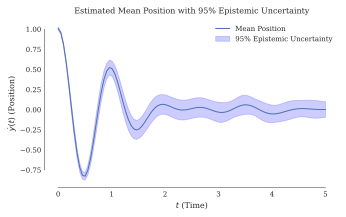

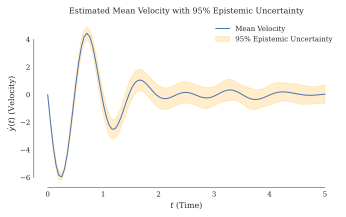

In [ ]:
samples = take_samples_from_solver(100)
# Sampled positions are: samples[:, :, 0]
# Sampled velocities are: samples[:, :, 1]
# Sampled position at the 10th timestep is: samples[:, 9, 0]
# etc.

# Calculate the mean and standard deviation for position and velocity over time
mean_position = np.mean(samples[:, :, 0], axis=0)
std_position = np.std(samples[:, :, 0], axis=0)
mean_velocity = np.mean(samples[:, :, 1], axis=0)
std_velocity = np.std(samples[:, :, 1], axis=0)

# Number of samples
n = samples.shape[0]

# Calculate the 95% epistemic uncertainty interval using the t-distribution
# For a 95% confidence interval, alpha = 0.05. We need alpha/2 in each tail.
alpha = 0.05
t_crit = st.t.ppf(1 - alpha/2, df=n-1)

ci_position = t_crit * (std_position / np.sqrt(n))
ci_velocity = t_crit * (std_velocity / np.sqrt(n))

# Plot the estimated mean position and velocity with uncertainty intervals
fig1, ax1 = make_full_width_fig()
ax1.plot(solver.t, mean_position, label='Mean Position')
ax1.fill_between(solver.t, mean_position - ci_position, mean_position + ci_position, color='blue', alpha=0.2, label='95% Epistemic Uncertainty')
ax1.set_xlabel('$t$ (Time)')
ax1.set_ylabel(r'$\dot{y}(t)$ (Position)')
ax1.set_title('Estimated Mean Position with 95% Epistemic Uncertainty')
ax1.legend(loc="best", frameon=False)
sns.despine(trim=True)

fig2, ax2 = make_full_width_fig()
ax2.plot(solver.t, mean_velocity, label='Mean Velocity')
ax2.fill_between(solver.t, mean_velocity - ci_velocity, mean_velocity + ci_velocity, color='orange', alpha=0.2, label='95% Epistemic Uncertainty')
ax2.set_xlabel('$t$ (Time)')
ax2.set_ylabel(r'$\dot{y}(t)$ (Velocity)')
ax2.set_title('Estimated Mean Velocity with 95% Epistemic Uncertainty')
ax2.legend(loc="best", frameon=False)
sns.despine(trim=True)

### Part B

Plot the epistemic uncertainty about the mean position at $t=5$s as a function of the number of samples.

**Solution**:

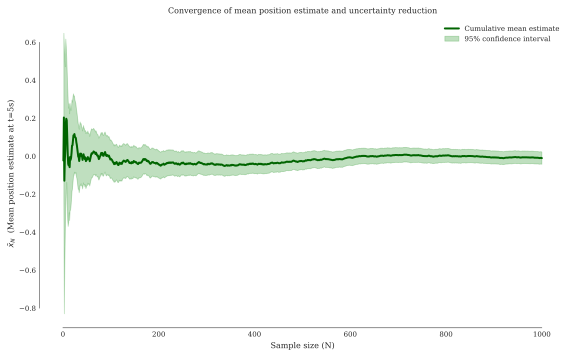

In [ ]:
# Your code here
n_samples = 1000   # total Monte Carlo draws

# Generate all realizations at once
data = take_samples_from_solver(n_samples)
pos_5sec = data[:, -1, 0]   # extract position at 5 seconds

# Compute cumulative average (running mean)
avg_progression = np.cumsum(pos_5sec) / np.arange(1, n_samples + 1)

# Initialize list for 95% confidence interval half-widths
ci_halfwidths = []

# Loop through each sample count to compute standard error and CI width
for k in range(1, n_samples + 1):
    if k > 1:
        sample_std = np.std(pos_5sec[:k], ddof=1)       # sample standard deviation
        std_error = sample_std / np.sqrt(k)             # standard error
        ci_halfwidths.append(1.96 * std_error)          # 95% CI half-width
    else:
        ci_halfwidths.append(np.nan)

ci_halfwidths = np.array(ci_halfwidths)

# Plotting
fig, axis = plt.subplots(figsize=(8, 5))

# Running mean line
axis.plot(np.arange(1, n_samples + 1), avg_progression,
          color='darkgreen', linewidth=2,
          label='Cumulative mean estimate')

# Confidence interval shaded region
axis.fill_between(np.arange(1, n_samples + 1),
                  avg_progression - ci_halfwidths,
                  avg_progression + ci_halfwidths,
                  color='green', alpha=0.25,
                  label='95% confidence interval')

# Plot aesthetics
axis.set_xlabel("Sample size (N)")
axis.set_ylabel(r"$\bar{x}_N$  (Mean position estimate at t=5s)")
axis.set_title("Convergence of mean position estimate and uncertainty reduction")
axis.legend(frameon=False)
sns.despine(trim=True)

### Part C

Repeat parts A and B for the squared response.
That is, do the same thing as above, but consider $y^2(t)$ and $\dot{y}^2(t)$ instead of $y(t)$ and $\dot{y}(t)$.
How many samples do you need to estimate the mean squared response at $t=5$s with negligible epistemic uncertainty?

**Solution**:

<>:46: SyntaxWarning: invalid escape sequence '\d'
<>:46: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-57033822.py:46: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title('Estimated Mean $\dot y^2(t)$ with 95% Epistemic Uncertainty (N=100)')


===== Estimated samples needed for ≤ 1.0% relative CI: **N ≈ 21791** =====


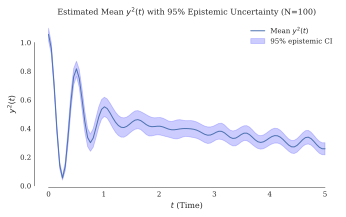

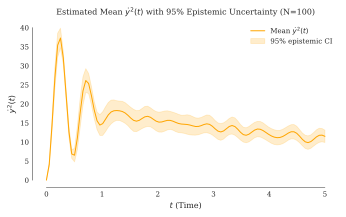

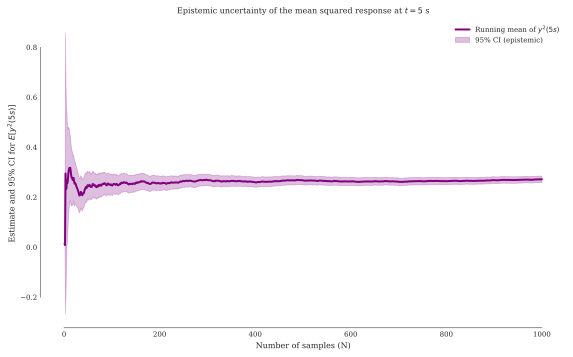

In [ ]:
# Your code here
# Take 100 samples
samples_sq = take_samples_from_solver(100)

# Square the responses
pos_sq = samples_sq[:, :, 0]**2
vel_sq = samples_sq[:, :, 1]**2

# Means & stds over the Monte Carlo samples (axis=0 = over samples, keep time dimension)
mean_pos_sq = np.mean(pos_sq, axis=0)
std_pos_sq  = np.std(pos_sq,  axis=0, ddof=1)

mean_vel_sq = np.mean(vel_sq, axis=0)
std_vel_sq  = np.std(vel_sq,  axis=0, ddof=1)

# 95% epistemic CI using t-crit (CLT style, small-N correction via t)
n = pos_sq.shape[0]
alpha = 0.05
t_crit = st.t.ppf(1 - alpha/2, df=n-1)

ci_pos_sq = t_crit * (std_pos_sq / np.sqrt(n))
ci_vel_sq = t_crit * (std_vel_sq / np.sqrt(n))

# Plot: mean y^2 with CI
fig, ax = make_full_width_fig()
ax.plot(solver.t, mean_pos_sq, label=r'Mean $y^2(t)$')
ax.fill_between(solver.t,
                mean_pos_sq - ci_pos_sq,
                mean_pos_sq + ci_pos_sq,
                color='blue', alpha=0.2, label='95% epistemic CI')
ax.set_xlabel('$t$ (Time)')
ax.set_ylabel(r'$y^2(t)$')
ax.set_title('Estimated Mean $y^2(t)$ with 95% Epistemic Uncertainty (N=100)')
ax.legend(loc="best", frameon=False)
sns.despine(trim=True)

# Plot: mean \dot{y}^2 with CI
fig, ax = make_full_width_fig()
ax.plot(solver.t, mean_vel_sq, label=r'Mean $\dot y^2(t)$', color='orange')
ax.fill_between(solver.t,
                mean_vel_sq - ci_vel_sq,
                mean_vel_sq + ci_vel_sq,
                color='orange', alpha=0.2, label='95% epistemic CI')
ax.set_xlabel('$t$ (Time)')
ax.set_ylabel(r'$\dot y^2(t)$')
ax.set_title('Estimated Mean $\dot y^2(t)$ with 95% Epistemic Uncertainty (N=100)')
ax.legend(loc="best", frameon=False)
sns.despine(trim=True)


# Settings
N_max   = 1000
z = 1.96
rel_tol = 0.01

# Draw samples and extract y^2 at t = 5s
S = take_samples_from_solver(N_max)
y2_5s = S[:, -1, 0]**2

# Running mean
running_mean_y2 = np.cumsum(y2_5s) / np.arange(1, N_max + 1)

# Running std (sample) with correct length (N_max); NaN at index 0
running_std_y2 = np.empty(N_max, dtype=float)
running_std_y2[:] = np.nan
for k in range(2, N_max + 1):
    running_std_y2[k-1] = np.std(y2_5s[:k], ddof=1)

# 95% CI half-width via CLT
n_vec = np.arange(1, N_max + 1)
ci_half_y2 = z * running_std_y2 / np.sqrt(n_vec)  # shapes now match (1000,)

# Compute theoretical number of samples needed for a given tolerance
z = 1.96                     # 95% CI
tol = 0.01                   # desired relative tolerance (1%)
mean_y2 = np.mean(y2_5s)     # sample mean
std_y2 = np.std(y2_5s, ddof=1)  # sample std deviation

# CLT formula for required sample size
N_required = (z * std_y2 / (tol * mean_y2))**2

print(f"===== Estimated samples needed for ≤ {tol*100:.1f}% relative CI: "
      f"**N ≈ {int(np.ceil(N_required))}** =====")

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(n_vec, running_mean_y2, color='purple', lw=2, label='Running mean of $y^2(5s)$')
ax.fill_between(n_vec,
                running_mean_y2 - ci_half_y2,
                running_mean_y2 + ci_half_y2,
                color='purple', alpha=0.25, label='95% CI (epistemic)')
if N_star is not None:
    ax.axvline(N_star, color='k', ls='--', lw=1)
    ax.text(N_star, running_mean_y2[min(N_star, N_max-1)],
            f'N*={N_star}', va='bottom', ha='left')
ax.set_xlabel('Number of samples (N)')
ax.set_ylabel(r'Estimate and 95% CI for $E[y^2(5s)]$')
ax.set_title(r'Epistemic uncertainty of the mean squared response at $t=5$ s')
ax.legend(frameon=False)
sns.despine(trim=True)

### Part D

Now that you know how many samples you need to estimate the mean of the response and the square response, use the formula:

$$
\mathbb{V}[y(t)] = \mathbb{E}[y^2(t)] - \left(\mathbb{E}[y(t)]\right)^2,
$$

and similarly, for $\dot{y}(t)$, to estimate the position and velocity variance with negligible epistemic uncertainty.
Plot both quantities as a function of time.

**Solution**:

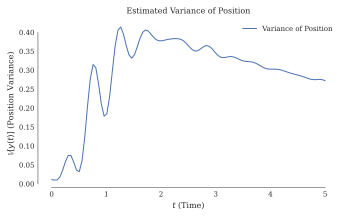

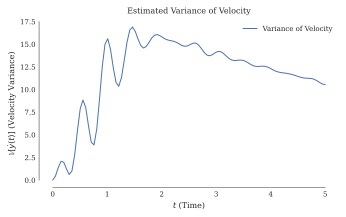

In [ ]:
# Estimate variance using the formula: Var(Y) = E[Y^2] - (E[Y])^2

# Use a number of samples sufficient for negligible epistemic uncertainty (based on Part C)
num_samples_for_variance = 2000 # Using a value slightly higher than the estimate from Part C

samples_for_variance = take_samples_from_solver(num_samples_for_variance)
samples_squared_for_variance = samples_for_variance**2

# Calculate the mean position and velocity
mean_position_for_variance = np.mean(samples_for_variance[:, :, 0], axis=0)
mean_velocity_for_variance = np.mean(samples_for_variance[:, :, 1], axis=0)

# Calculate the mean squared position and velocity
mean_position_squared_for_variance = np.mean(samples_squared_for_variance[:, :, 0], axis=0)
mean_velocity_squared_for_variance = np.mean(samples_squared_for_variance[:, :, 1], axis=0)

# Calculate the variance
variance_position = mean_position_squared_for_variance - (mean_position_for_variance)**2
variance_velocity = mean_velocity_squared_for_variance - (mean_velocity_for_variance)**2

# Plot the estimated variance of position and velocity
fig6, ax6 = make_full_width_fig()
ax6.plot(solver.t, variance_position, label='Variance of Position')
ax6.set_xlabel('$t$ (Time)')
ax6.set_ylabel(r'$\mathbb{V}[y(t)]$ (Position Variance)')
ax6.set_title('Estimated Variance of Position')
ax6.legend(loc="best", frameon=False)
sns.despine(trim=True)

fig7, ax7 = make_full_width_fig()
ax7.plot(solver.t, variance_velocity, label='Variance of Velocity')
ax7.set_xlabel('$t$ (Time)')
ax7.set_ylabel(r'$\mathbb{V}[\dot{y}(t)]$ (Velocity Variance)')
ax7.set_title('Estimated Variance of Velocity')
ax7.legend(loc="best", frameon=False)
sns.despine(trim=True)

### Part E

Put together the estimated mean and variance to plot a 95\% predictive interval for the position and the velocity as functions of time.

**Solution**:


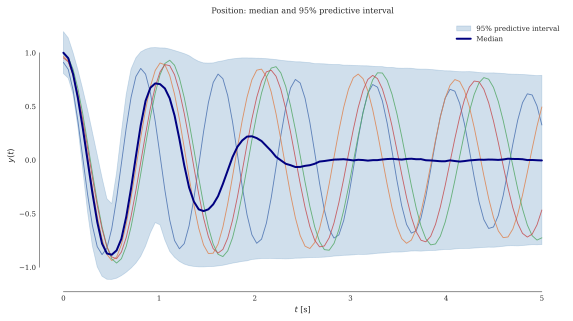

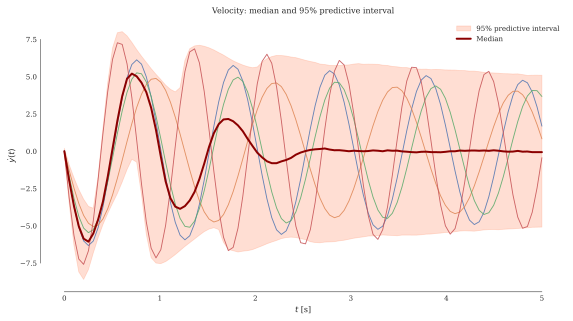

In [ ]:
# Your code here
N_pred = 22000  # Monte Carlo samples for predictive band estimation

# Draw samples
data_pred = take_samples_from_solver(N_pred)
pos_samples = data_pred[:, :, 0]
vel_samples = data_pred[:, :, 1]
time_grid = solver.t

# --- Helper function: median and quantile bands ---
def predictive_band(data_2d, lower=2.5, upper=97.5):
    """Compute median and predictive band (2.5–97.5%) along time axis."""
    median_curve = np.median(data_2d, axis=0)
    q_lower = np.percentile(data_2d, lower, axis=0)
    q_upper = np.percentile(data_2d, upper, axis=0)
    return median_curve, q_lower, q_upper

# Compute empirical predictive intervals
pos_med, pos_low, pos_high = predictive_band(pos_samples)
vel_med, vel_low, vel_high = predictive_band(vel_samples)

# --- Position plot ---
fig_pos, ax_pos = plt.subplots(figsize=(8, 4.5))
ax_pos.fill_between(time_grid, pos_low, pos_high, color='steelblue',
                    alpha=0.25, label='95% predictive interval')

# Overlay a few random trajectories
for _ in range(4):
    i = np.random.randint(0, N_pred)
    ax_pos.plot(time_grid, pos_samples[i], lw=0.9, alpha=0.85)

ax_pos.plot(time_grid, pos_med, color='navy', lw=2.0, label='Median')
ax_pos.set_xlabel(r"$t$ [s]")
ax_pos.set_ylabel(r"$y(t)$")
ax_pos.set_title("Position: median and 95% predictive interval")
ax_pos.legend(frameon=False)
sns.despine(trim=True)

# --- Velocity plot ---
fig_vel, ax_vel = plt.subplots(figsize=(8, 4.5))
ax_vel.fill_between(time_grid, vel_low, vel_high, color='coral',
                    alpha=0.25, label='95% predictive interval')

for _ in range(4):
    j = np.random.randint(0, N_pred)
    ax_vel.plot(time_grid, vel_samples[j], lw=0.9, alpha=0.85)

ax_vel.plot(time_grid, vel_med, color='darkred', lw=2.0, label='Median')
ax_vel.set_xlabel(r"$t$ [s]")
ax_vel.set_ylabel(r"$\dot{y}(t)$")
ax_vel.set_title("Velocity: median and 95% predictive interval")
ax_vel.legend(frameon=False)
sns.despine(trim=True)

## Problem 2 - Earthquakes again

The [San Andreas fault](https://en.wikipedia.org/wiki/San_Andreas_Fault) extends through California, forming the boundary between the Pacific and the North American tectonic plates.
It has caused some of the most significant earthquakes on Earth.
We are going to focus on Southern California, and we would like to assess the probability of a significant earthquake, defined as an earthquake of magnitude 6.5 or greater, during the next ten years.

A. The first thing we will do is review a [database of past earthquakes](https://scedc.caltech.edu/significant/chron-index.html) that have occurred in Southern California and collect the relevant data. We will start at 1900 because data before that time may be unreliable.
Go over each decade and count the occurrence of a significant earthquake (i.e., count the number of orange and red colors in each decade). We have done this for you.

In [ ]:
eq_data = np.array([
    0, # 1900-1909
    1, # 1910-1919
    2, # 1920-1929
    0, # 1930-1939
    3, # 1940-1949
    2, # 1950-1959
    1, # 1960-1969
    2, # 1970-1979
    1, # 1980-1989
    4, # 1990-1999
    0, # 2000-2009
    2 # 2010-2019
])

Let's visualize them:

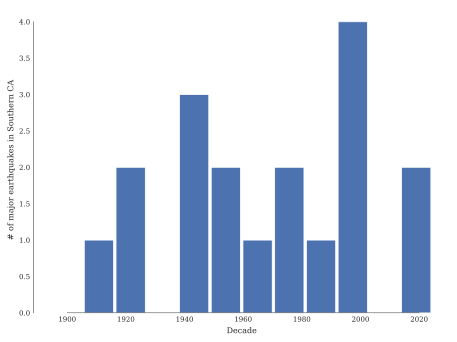

In [ ]:
fig, ax = plt.subplots()
ax.bar(
    np.linspace(1900, 2019, eq_data.shape[0]),
    eq_data,
    width=10
)
ax.set_xlabel('Decade')
ax.set_ylabel('# of major earthquakes in Southern CA')
sns.despine(trim=True);

A. The right way to model the number of earthquakes $X_n$ in a decade $n$ is using a Poisson distribution with unknown rate parameter $\lambda$, i.e.,

$$
X_n | \lambda \sim \operatorname{Poisson}(\lambda).
$$

The probability mass function is:

$$
p(x_n|\lambda) \equiv p(X_n=x_n|\lambda) = \frac{\lambda^{x_n}}{x_n!}e^{-\lambda}.
$$

Here we have $N = 12$ observations, say $x_{1:N} = (x_1,\dots,x_N)$ (stored in `eq_data` above).
Find the *joint probability mass function* (otherwise known as the likelihood) $p(x_{1:N}|\lambda)$ of these random variables.

**Hint:** Assume that all measurements are independent. Then, their joint PMF is the product of the individual PMFs.
You should be able to simplify the expression.

**Answer:**

Since the measurements are independent, the joint PMF is the product of the individual PMFs:

$$
p(x_{1:N}|\lambda) = \prod_{n=1}^N p(x_n|\lambda) = \prod_{n=1}^N \frac{\lambda^{x_n}}{x_n!}e^{-\lambda}
$$

We can simplify this expression:

$$
p(x_{1:N}|\lambda) = \left(\prod_{n=1}^N \frac{1}{x_n!}\right) \left(\prod_{n=1}^N \lambda^{x_n}\right) \left(\prod_{n=1}^N e^{-\lambda}\right)
$$

$$
p(x_{1:N}|\lambda) = \left(\frac{1}{\prod_{n=1}^N x_n!}\right) \lambda^{\sum_{n=1}^N x_n} e^{-N\lambda}
$$

Let $S = \sum_{n=1}^N x_n$. Then the likelihood can be written as:

$$
p(x_{1:N}|\lambda) = \frac{1}{\prod_{n=1}^N x_n!} \lambda^{S} e^{-N\lambda}
$$

Let's calculate the log likelihood, which is $\ln(p(x_{1:N}|\lambda))$.

Starting from the likelihood expression:
$$
p(x_{1:N}|\lambda) = \frac{1}{\prod_{n=1}^N x_n!} \lambda^{S} e^{-N\lambda}
$$

Taking the natural logarithm of both sides and using logarithm properties ($\ln(ab) = \ln(a) + \ln(b)$, $\ln(a^b) = b\ln(a)$, $\ln(e^x) = x$, and $\ln(\prod a_i) = \sum \ln(a_i)$):
$$
\ln(p(x_{1:N}|\lambda)) = \ln\left(\frac{1}{\prod_{n=1}^N x_n!}\right) + \ln(\lambda^{S}) + \ln(e^{-N\lambda})
$$
$$
\ln(p(x_{1:N}|\lambda)) = -\sum_{n=1}^N \ln(x_n!) + S\ln(\lambda) - N\lambda
$$

For the specific earthquake data, where $N=12$ and $S=18$:
$$
\ln(p(x_{1:12}|\lambda)) = -\sum_{n=1}^{12} \ln(x_n!) + 18\ln(\lambda) - 12\lambda
$$

Note that the term $-\sum_{n=1}^{12} \ln(x_n!)$ is a constant with respect to $\lambda$ and is often ignored when maximizing the log likelihood to find the maximum likelihood estimate (MLE) of $\lambda$.

B. The rate parameter $\lambda$ (number of significant earthquakes per ten years) is positive. What prior distribution should we assign to it if we expect it to be around 2?
A convenient choice is to pick a [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution). See also [the scipy.stats page for the Gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) because it results in an analytical posterior.
We write:

$$
\lambda \sim \operatorname{Gamma}(\alpha, \beta),
$$

where $\alpha$ and $\beta$ are positive *hyper-parameters* that we must set to represent our prior state of knowledge.
The PDF is:

$$
p(\lambda) = \frac{\beta^\alpha \lambda^{\alpha-1}e^{-\beta \lambda}}{\Gamma(\alpha)},
$$

where we are not conditioning on $\alpha$ and $\beta$ because they should be fixed numbers.
Use the code below to pick reasonable values for $\alpha$ and $\beta$.
<br>
**Just enter your choice of $\alpha$ and $\beta$ in the code block below.**
<br>

**Hint:** Notice that the maximum entropy distribution for a positive parameter with known expectation is the [Exponential](https://en.wikipedia.org/wiki/Exponential_distribution), e.g., see the Table in [this wiki page](https://en.wikipedia.org/wiki/Maximum_entropy_probability_distribution). Then, notice that the Exponential is a particular case of the Gamma (set $\alpha=1$).

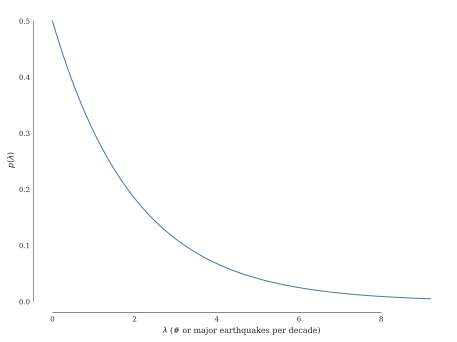

In [ ]:
import scipy.stats as st

# You have to pick an alpha:
alpha = 1.0
# And you have to pick a beta:
beta = 0.5

# This is the prior on lambda:
lambda_prior = st.gamma(alpha, scale=1.0 / beta)

# Let's plot it:
lambdas = np.linspace(0, lambda_prior.ppf(0.99), 100)
fig, ax = plt.subplots()
ax.plot(lambdas, lambda_prior.pdf(lambdas))
ax.set_xlabel(r'$\lambda$ (# or major earthquakes per decade)')
ax.set_ylabel(r'$p(\lambda)$')
sns.despine(trim=True);

C. Show that the posterior of $\lambda$ conditioned on $x_{1:N}$ is also a Gamma, but with updated hyperparameters.

**Hint:** When you write down the posterior of $\lambda$ you can drop any multiplicative term that does not depend on it as it will be absorbed in the normalization constant. This will simplify the notation a little bit.

**Answer:**

The posterior distribution is proportional to the likelihood times the prior:
$$
p(\lambda|x_{1:N}) \propto p(x_{1:N}|\lambda) p(\lambda)
$$

From Part A, the likelihood is:
$$
p(x_{1:N}|\lambda) = \frac{1}{\prod_{n=1}^N x_n!} \lambda^{\sum_{n=1}^N x_n} e^{-N\lambda}
$$

From Part B, the prior (Gamma distribution) is:
$$
p(\lambda) = \frac{\beta^\alpha \lambda^{\alpha-1}e^{-\beta \lambda}}{\Gamma(\alpha)}
$$

Now, let's multiply the likelihood and the prior, and drop terms that do not depend on $\lambda$:
$$
p(\lambda|x_{1:N}) \propto \left(\lambda^{\sum_{n=1}^N x_n} e^{-N\lambda}\right) \left(\lambda^{\alpha-1}e^{-\beta \lambda}\right)
$$

Combine the terms with the same base:
$$
p(\lambda|x_{1:N}) \propto \lambda^{\sum_{n=1}^N x_n + \alpha - 1} e^{-N\lambda - \beta \lambda}
$$

$$
p(\lambda|x_{1:N}) \propto \lambda^{(\sum_{n=1}^N x_n + \alpha) - 1} e^{-(N + \beta) \lambda}
$$

This expression has the form of a Gamma distribution with updated hyperparameters. The PDF of a Gamma distribution is proportional to $\lambda^{k-1}e^{-\theta \lambda}$, where $k$ is the shape parameter and $\theta$ is the rate parameter (which corresponds to $\beta$ in the parameterization used in the problem description).

Comparing the derived expression to the Gamma PDF form, we can identify the updated hyperparameters:

New shape parameter (let's call it $\alpha_{post}$):
$$
\alpha_{post} = \sum_{n=1}^N x_n + \alpha
$$

New rate parameter (let's call it $\beta_{post}$):
$$
\beta_{post} = N + \beta
$$

So, the posterior distribution of $\lambda$ is a Gamma distribution with hyperparameters $\alpha_{post} = \alpha + \sum_{n=1}^N x_n$ and $\beta_{post} = \beta + N$.

The expected value of the posterior distribution is the mean of this Gamma distribution:
$$
\mathbb{E}[\lambda|x_{1:N}] = \frac{\alpha_{post}}{\beta_{post}} = \frac{\alpha + \sum_{n=1}^N x_n}{\beta + N}
$$

D. Prior-likelihood pairs that result in a posterior with the same form as the prior are known as conjugate distributions. Conjugate distributions are your only hope for analytical Bayesian inference.
As a verification check, look at the Wikipedia page for [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior), locate the Poisson-Gamma pair, and verify your answer above.
<br>
*Nothing to report here. Just do it as a verification check.*

E. Plot the prior and the posterior of $\lambda$ on the same plot.

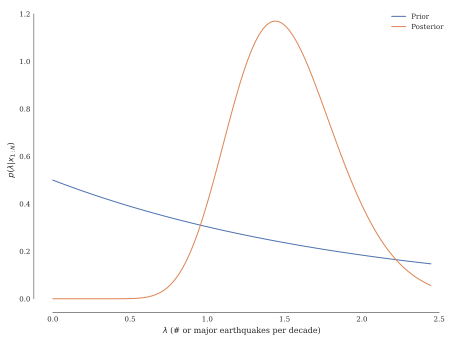

In [ ]:
# Your expression for alpha posterior here:
alpha_post = alpha + np.sum(eq_data)
# Your expression for beta posterior here:
beta_post = beta + len(eq_data)
# The posterior
lambda_post = st.gamma(alpha_post, scale=1.0 / beta_post)

# Plot it
lambdas = np.linspace(0, lambda_post.ppf(0.99), 100)
fig, ax = plt.subplots()
ax.plot(lambdas, lambda_prior.pdf(lambdas), label='Prior')
ax.plot(lambdas, lambda_post.pdf(lambdas), label='Posterior')
ax.set_xlabel(r'$\lambda$ (# or major earthquakes per decade)')
ax.set_ylabel(r'$p(\lambda|x_{1:N})$')
ax.legend(loc="best", frameon=False)
sns.despine(trim=True);

F. Let's determine the predictive distribution for the number of significant earthquakes during the next decade.
This is something we did not do in class, but it will reappear in future lectures.
Let $X$ be the random variable corresponding to the number of significant earthquakes during the next decade.
We need to calculate:

$$
p(x|x_{1:N}) = \text{our state of knowledge about $X$ after seeing the data}.
$$

How do we do this?
We use the sum rule:

$$
p(x|x_{1:N}) = \int_{0}^\infty p(x|\lambda, x_{1:N}) p(\lambda|x_{1:N})d\lambda = \int_{0}^\infty p(x|\lambda) p(\lambda|x_{1:N})d\lambda,
$$

where going from the middle step to the rightmost one, we assumed that the number of earthquakes occurring in each decade is independent.
You can carry out this integration analytically (it gives a [negative Binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution) distribution), but we are not going to bother with it.

Below, you will write code to characterize it using Monte Carlo sampling.
You can take a sample from the posterior predictive by:

+ sampling a $\lambda$ from its posterior $p(\lambda|x_{1:N})$.
+ sampling an $x$ from the likelihood $p(x|\lambda)$.

This is the same procedure we used for replicated experiments.

Complete the code below:

In [ ]:
def sample_posterior_predictive(n, lambda_post):
    """Sample from the posterior predictive.

    Arguments
    n           -- The number of samples to take.
    lambda_post -- The posterior for lambda.

    Returns n samples from the posterior
    """
    samples = np.empty((n,), dtype="i")
    for i in range(n):
        lambda_sample = lambda_post.rvs(size=1)[0]
        samples[i] = st.poisson.rvs(lambda_sample, size=1)[0]
    return samples

Test your code here:

In [ ]:
samples = sample_posterior_predictive(10, lambda_post)
samples

array([0, 2, 1, 1, 0, 0, 2, 2, 1, 4], dtype=int32)

G. Plot the predictive distribution $p(x|x_{1:N})$.
<br>

**Hint:** Draw 1,000 samples using `sample_posterior_predictive` and then draw a histogram.

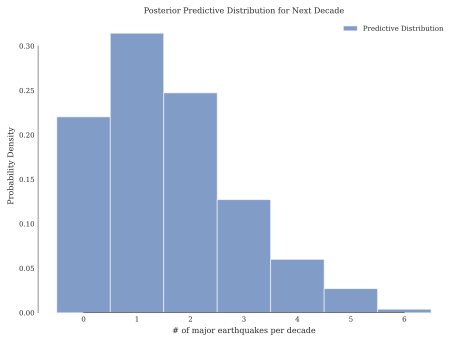

In [ ]:
# Your code here
num_samples = 1000
predictive_samples = sample_posterior_predictive(num_samples, lambda_post)

fig, ax = plt.subplots()
ax.hist(predictive_samples, bins=np.arange(predictive_samples.min(), predictive_samples.max() + 1) - 0.5, density=True, alpha=0.7, label='Predictive Distribution')
ax.set_xlabel('# of major earthquakes per decade')
ax.set_ylabel('Probability Density')
ax.set_title('Posterior Predictive Distribution for Next Decade')
ax.legend(loc="best", frameon=False)
sns.despine(trim=True);

H. What is the probability that at least one major earthquake will occur during the next decade?
<br>

**Hint:** You may use a Monte Carlo estimate of the probability. Ignore the uncertainty in the estimate.

In [ ]:
num_samples = 10000
samples = sample_posterior_predictive(num_samples, lambda_post)

# Count how many major earthquakes occured:
count = 0
for i in range(num_samples):
    if samples[i] >=1:
        count += 1

prob_of_major_eq = count / num_samples # YOUR ESTIMATE HERE

print(f"p(X >= 1 | data) = {prob_of_major_eq}")

p(X >= 1 | data) = 0.7628


I. Find a 95\% credible interval for $\lambda$.

In [ ]:
# Write your code here and print() your answer

# Calculate the 95% credible interval for lambda using the posterior Gamma distribution
lower_bound = lambda_post.ppf(0.025)
upper_bound = lambda_post.ppf(0.975)

print(f"The 95% credible interval for lambda is: ({lower_bound:.4f}, {upper_bound:.4f})")

The 95% credible interval for lambda is: (0.9151, 2.2758)


J. Find the $\lambda$ that minimizes the absolute loss (see lecture), and call it $\lambda^*_N$.
Then, plot the fully Bayesian predictive $p(x|x_{1:N})$ in the same figure as $p(x|\lambda^*_N)$.

The lambda that minimizes the absolute loss (median of the posterior) is: 1.4934


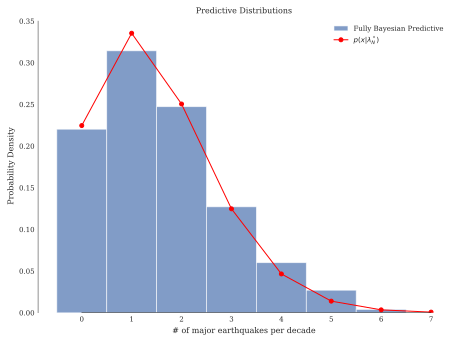

In [ ]:
# Find the lambda that minimizes the absolute loss (the median of the posterior)
lambda_star_N = lambda_post.median()

print(f"The lambda that minimizes the absolute loss (median of the posterior) is: {lambda_star_N:.4f}")

# Plot the fully Bayesian predictive p(x|x_1:N) and p(x|lambda*_N)

# Use the predictive samples generated in Part G
# If you ran the notebook sequentially, these samples should be available in the 'predictive_samples' variable.
# If not, you might need to regenerate them:
# num_samples = 1000
# predictive_samples = sample_posterior_predictive(num_samples, lambda_post)


# Plot the histogram of the fully Bayesian predictive distribution
fig, ax = plt.subplots()
ax.hist(predictive_samples, bins=np.arange(predictive_samples.min(), predictive_samples.max() + 1) - 0.5, density=True, alpha=0.7, label='Fully Bayesian Predictive')

# Plot the Poisson PMF conditioned on lambda*_N
x_values = np.arange(0, predictive_samples.max() + 1)
poisson_pmf = st.poisson.pmf(x_values, lambda_star_N)
ax.plot(x_values, poisson_pmf, 'o-', color='red', label=r'$p(x|\lambda^*_{N})$')

ax.set_xlabel('# of major earthquakes per decade')
ax.set_ylabel('Probability Density')
ax.set_title('Predictive Distributions')
ax.legend(loc="best", frameon=False)
sns.despine(trim=True);

L. Draw replicated data from the model and compare them to the observed data.

<br>

**Hint:** Complete the missing code at the places indicated below.

In [ ]:
def replicate_experiment(post_rv, n=len(eq_data), n_rep=9):
    """Replicate the experiment.

    Arguments
    post_rv -- The random variable object corresponding to
               the posterior from which to sample.
    n       -- The number of observations.
    nrep    -- The number of repetitions.

    Returns:
    A numpy array of size n_rep x n.
    """
    x_rep = np.empty((n_rep, n), dtype="i")
    for i in range(n_rep):
        lambda_sample = post_rv.rvs(size=1)[0] # Sample lambda from the posterior
        x_rep[i, :] = st.poisson.rvs(lambda_sample, size=n) # Sample n observations from Poisson given lambda
    return x_rep

Try your code here:

In [ ]:
x_rep = replicate_experiment(lambda_post)
x_rep

array([[2, 3, 0, 1, 1, 1, 1, 2, 0, 2, 2, 5],
       [5, 1, 4, 2, 2, 4, 3, 2, 2, 2, 0, 2],
       [1, 1, 2, 0, 1, 0, 1, 0, 2, 0, 2, 3],
       [0, 1, 1, 2, 2, 2, 0, 1, 2, 1, 4, 1],
       [0, 1, 2, 0, 3, 2, 1, 0, 3, 0, 0, 3],
       [0, 3, 2, 1, 2, 1, 1, 1, 0, 0, 0, 0],
       [1, 0, 2, 1, 5, 2, 1, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 3, 1, 1, 1, 2, 1, 2, 0],
       [2, 2, 1, 1, 0, 2, 1, 0, 1, 0, 1, 0]], dtype=int32)

If it works, then try the following visualization:

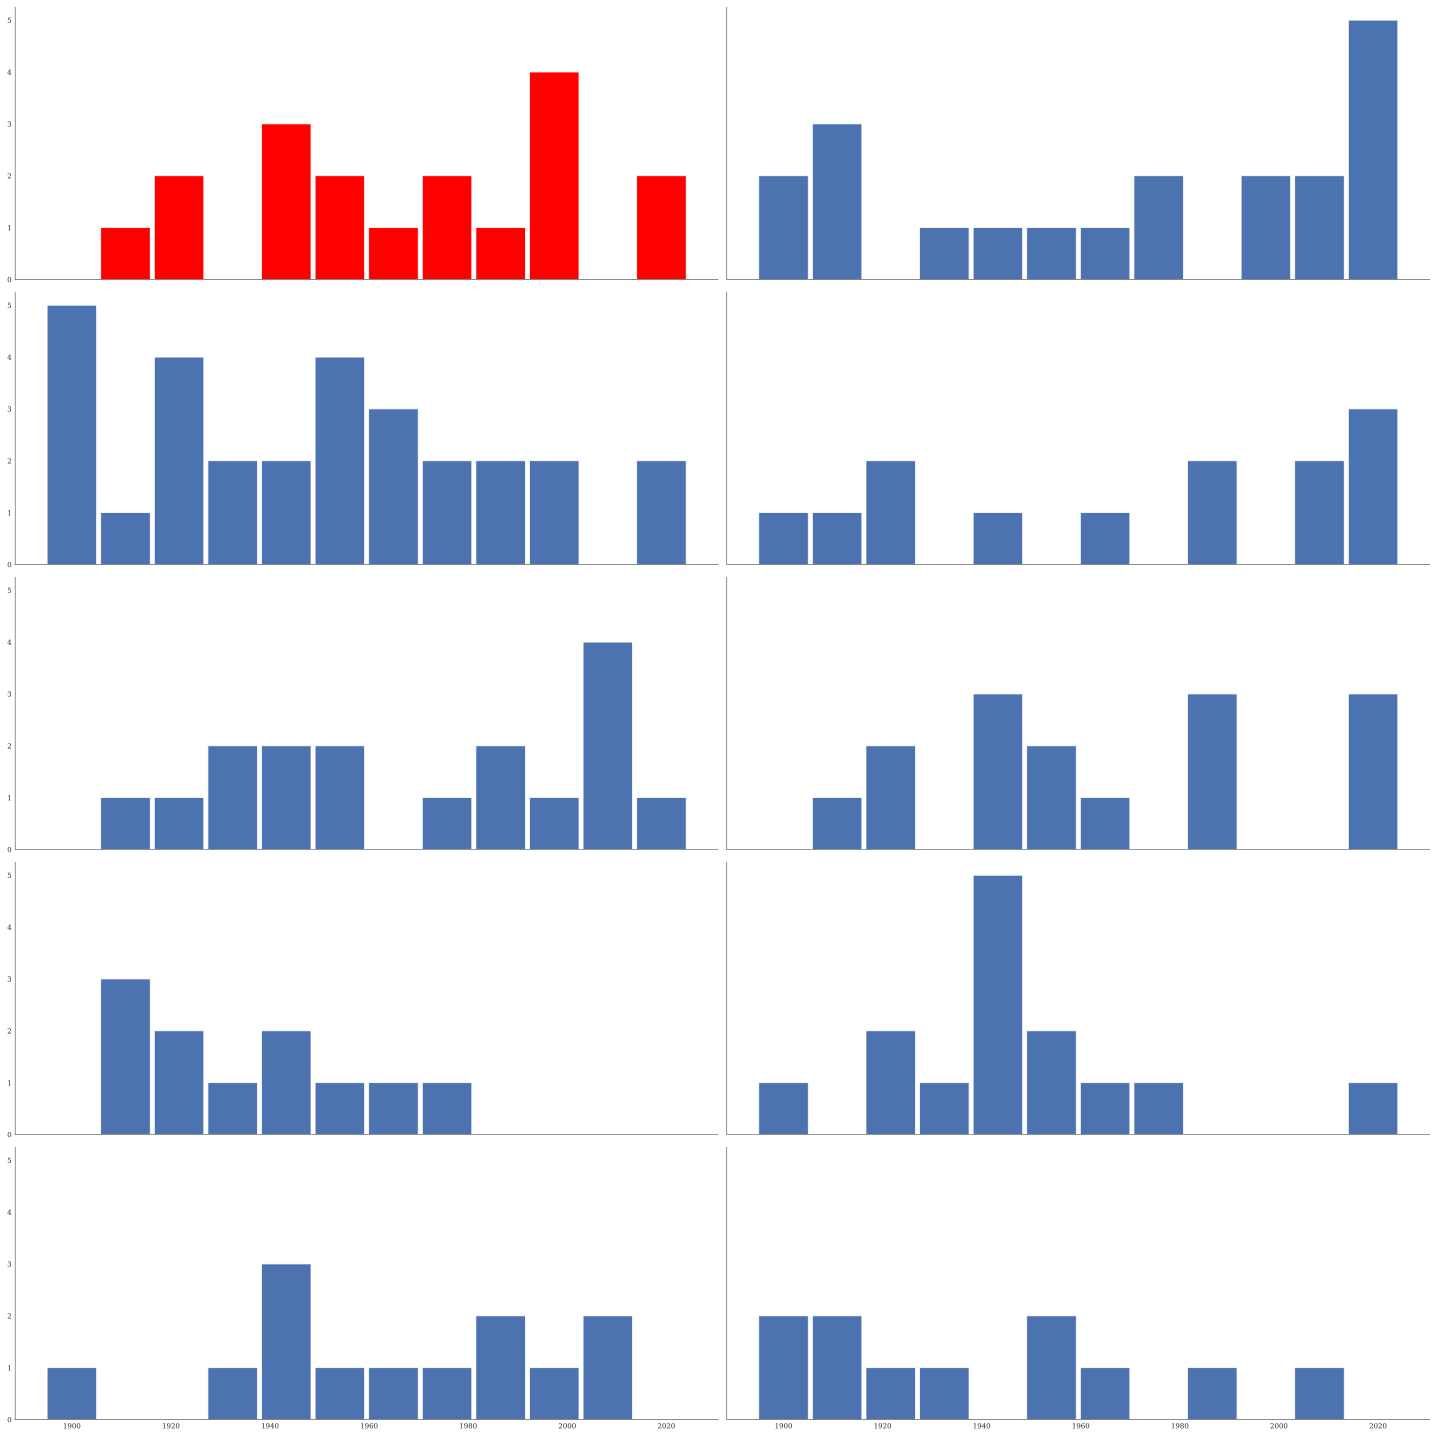

In [ ]:
fig, ax = plt.subplots(
    5,
    2,
    sharex='all',
    sharey='all',
    figsize=(20, 20)
)
ax[0, 0].bar(
    np.linspace(1900, 2019, eq_data.shape[0]),
    eq_data,
    width=10,
    color='red'
)
n_rep = 9 # Define n_rep here
for i in range(1, n_rep + 1):
    ax[int(i / 2), i % 2].bar(
        np.linspace(1900, 2019, eq_data.shape[0]),
        x_rep[i-1],
        width=10
    )

M. Plot the histograms and calculate the Bayesian p-values of the following test quantities:

+ Maximum number of consecutive decades with no earthquakes.
+ Maximum number of successive decades with earthquakes.

**Hint:** You may reuse the code from [Hands-on 12.4](https://predictivesciencelab.github.io/data-analytics-se/lecture12/hands-on-12.4.html).

In [ ]:
def perform_diagnostics(post_rv, data, test_func, n_rep=1000):
    """Calculate Bayesian p-values.

    Arguments
    post_rv   -- The random variable object corresponding to
                 the posterior from which to sample.
    data      -- The training data.
    test_func -- The test function.
    n         -- The number of observations.
    nrep      -- The number of repetitions.

    Returns a dictionary that includes the observed value of
    the test function (T_obs), the Bayesian p-value (p_val),
    the replicated test statistic (T_rep),
    and all the replicated data (data_rep).
    """
    T_obs = test_func(data)
    n = data.shape[0]
    data_rep = replicate_experiment(post_rv, n_rep=n_rep)
    T_rep = np.array(
        tuple(
            test_func(x)
            for x in data_rep
        )
    )
    p_val = (
        np.sum(np.ones((n_rep,))[T_rep > T_obs]) / n_rep
    )
    return dict(
        T_obs=T_obs,
        p_val=p_val,
        T_rep=T_rep,
        data_rep=data_rep
    )


def plot_diagnostics(diagnostics):
    """Make the diagnostics plot.

    Arguments:
    diagnostics -- The dictionary returned by perform_diagnostics()
    """
    fig, ax = plt.subplots()
    tmp = ax.hist(
        diagnostics["T_rep"],
        density=True,
        alpha=0.25,
        label='Replicated test quantity'
    )[0]
    ax.plot(
        diagnostics["T_obs"] * np.ones((50,)),
        np.linspace(0, tmp.max(), 50),
        'k',
        label='Observed test quantity'
    )
    plt.legend(loc='best');


def do_diagnostics(post_rv, data, test_func, n_rep=1000):
    """Calculate Bayesian p-values and make the corresponding
    diagnostic plot.

    Arguments
    post_rv   -- The random variable object corresponding to
                 the posterior from which to sample.
    data      -- The training data.
    test_func -- The test function.
    n         -- The number of observations.
    nrep      -- The number of repetitions.

    Returns a dictionary that includes the observed value of
    the test function (T_obs), the Bayesian p-value (p_val),
    and the replicated experiment (data_rep).
    """
    res = perform_diagnostics(
        post_rv,
        data,
        test_func,
        n_rep=n_rep
    )

    T_obs = res["T_obs"]
    p_val = res["p_val"]

    print(f'The observed test quantity is {T_obs}')
    print(f'The Bayesian p_value is {p_val:.4f}')

    plot_diagnostics(res)

In [ ]:
# Here is the first test function for you
def T_eq_max_neq(x):
    """Return the maximum number of consecutive decades
    with no earthquakes."""
    count = 0
    result = 0
    for i in range(x.shape[0]):
        if x[i] != 0:
            count = 0
        else:
            count += 1
            result = max(result, count)
    return result

# Consult the textbook (Lecture 12) to figure out
# how to use do_diagnostics().

Diagnostics for Maximum Number of Consecutive Decades with No Earthquakes:
The observed test quantity is 1
The Bayesian p_value is 0.4270


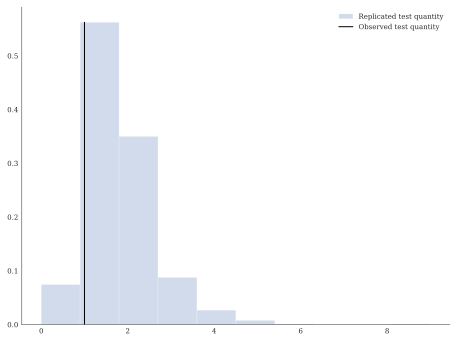

In [ ]:
# Calculate diagnostics for the maximum number of consecutive decades with no earthquakes
print("Diagnostics for Maximum Number of Consecutive Decades with No Earthquakes:")
do_diagnostics(lambda_post, eq_data, T_eq_max_neq)

In [ ]:
# Write your code here for the second test quantity
# (maximum number of consecutive decades with earthquakes)
# Hint: copy paste your code from the previous cell
# and make the necessary modifications

def T_eq_max_eq(x):
    """Return the maximum number of successive decades
    with earthquakes (number of earthquakes > 0)."""
    count = 0
    result = 0
    for i in range(x.shape[0]):
        if x[i] == 0:
            count = 0
        else:
            count += 1
            result = max(result, count)
    return result


Diagnostics for Maximum Number of Consecutive Decades with Earthquakes:
The observed test quantity is 6
The Bayesian p_value is 0.3850


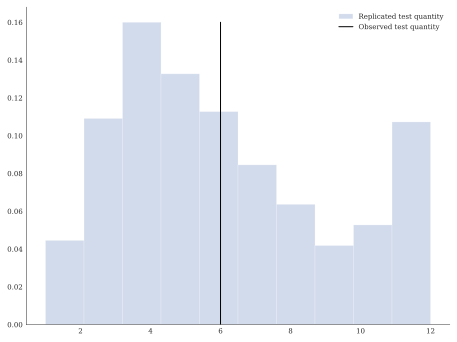

In [ ]:
# Calculate diagnostics for the maximum number of successive decades with earthquakes
print("\nDiagnostics for Maximum Number of Consecutive Decades with Earthquakes:")
do_diagnostics(lambda_post, eq_data, T_eq_max_eq)